# 데이터 소개

캐글 [DataCo SMART SUPPLY CHAIN FOR BIG DATA ANALYSIS](https://www.kaggle.com/datasets/shashwatwork/dataco-smart-supply-chain-for-big-data-analysis?utm_source=chatgpt.com)

주문(Order) ~ 출하(Shipment) ~ 배송(Delivery)까지 전 과정이 포함된 공급망 데이터

#0.기본세팅

In [65]:
#필요 라이브러리
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
import matplotlib.font_manager as fm
from matplotlib.ticker import PercentFormatter
import matplotlib.dates as mdates
from matplotlib.ticker import StrMethodFormatter

In [2]:
# 코랩 구글드라이브 마운트
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# 파일 불러오기

# 실제 분석 대상 데이터 (주문~출하~배송)
df1 = pd.read_csv(
    "/content/drive/MyDrive/분석/공급망_최적화/DataCoSupplyChainDataset.csv",encoding="latin1")

# 데이터 설명(사전)
df2 = pd.read_csv(
    "/content/drive/MyDrive/분석/공급망_최적화/DescriptionDataCoSupplyChain.csv",encoding="latin1")

# 토큰화 액세스 로그
df3 = pd.read_csv(
    "/content/drive/MyDrive/분석/공급망_최적화/tokenized_access_logs.csv",encoding="latin1")

In [5]:
#나눔 폰트 설치
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 35 not upgraded.
Need to get 10.3 MB of archives.
After this operation, 34.1 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 fonts-nanum all 20200506-1 [10.3 MB]
Fetched 10.3 MB in 0s (24.1 MB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 78, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package fonts-nanum.
(Reading database ... 126435 files and direc

In [6]:
# 그래프 한글깨짐 현상
font_path = "/usr/share/fonts/truetype/nanum/NanumGothic.ttf"

fm.fontManager.addfont(font_path)
prop = fm.FontProperties(fname=font_path)
mpl.rcParams['font.family'] = prop.get_name()
mpl.rcParams['axes.unicode_minus'] = False

#그래프 설정
pd.set_option("display.max_columns", 100)
pd.set_option("display.width", 150)
plt.rcParams["figure.figsize"] = (12, 4)

In [23]:
supply_chain_data = df1.copy()
supply_chain_desc = df2.copy()
access_logs = df3.copy()

In [16]:
supply_chain_data.head(3)

,Type,Days for shipping (real),Days for shipment (scheduled),Benefit per order,Sales per customer,Delivery Status,Late_delivery_risk,Category Id,Category Name,Customer City,Customer Country,Customer Email,Customer Fname,Customer Id,Customer Lname,Customer Password,Customer Segment,Customer State,Customer Street,Customer Zipcode,Department Id,Department Name,Latitude,Longitude,Market,Order City,Order Country,Order Customer Id,order date (DateOrders),Order Id,Order Item Cardprod Id,Order Item Discount,Order Item Discount Rate,Order Item Id,Order Item Product Price,Order Item Profit Ratio,Order Item Quantity,Sales,Order Item Total,Order Profit Per Order,Order Region,Order State,Order Status,Order Zipcode,Product Card Id,Product Category Id,Product Description,Product Image,Product Name,Product Price,Product Status,shipping date (DateOrders),Shipping Mode
0,DEBIT,3,4,91.250000,314.640015,Advance shipping,0,73,Sporting Goods,Caguas,Puerto Rico,XXXXXXXXX,Cally,20755,Holloway,XXXXXXXXX,Consumer,PR,5365 Noble Nectar Island,725.0,2,Fitness,18.251453,-66.037056,Pacific Asia,Bekasi,Indonesia,20755,1/31/2018 22:56,77202,1360,13.110000,0.04,180517,327.75,0.29,1,327.75,314.640015,91.250000,Southeast Asia,Java Occidental,COMPLETE,NaN,1360,73,NaN,http://images.acmesports.sports/Smart+watch,Smart watch,327.75,0,2/3/2018 22:56,Standard Class
1,TRANSFER,5,4,-249.089996,311.359985,Late delivery,1,73,Sporting Goods,Caguas,Puerto Rico,XXXXXXXXX,Irene,19492,Luna,XXXXXXXXX,Consumer,PR,2679 Rustic Loop,725.0,2,Fitness,18.279451,-66.037064,Pacific Asia,Bikaner,India,19492,1/13/2018 12:27,75939,1360,16.389999,0.05,179254,327.75,-0.80,1,327.75,311.359985,-249.089996,South Asia,Rajastán,PENDING,NaN,1360,73,NaN,http://images.acmesports.sports/Smart+watch,Smart watch,327.75,0,1/18/2018 12:27,Standard Class
2,CASH,4,4,-247.779999,309.720001,Shipping on time,0,73,Sporting Goods,San Jose,EE. UU.,XXXXXXXXX,Gillian,19491,Maldonado,XXXXXXXXX,Consumer,CA,8510 Round Bear Gate,95125.0,2,Fitness,37.292233,-121.881279,Pacific Asia,Bikaner,India,19491,1/13/2018 12:06,75938,1360,18.030001,0.06,179253,327.75,-0.80,1,327.75,309.720001,-247.779999,South Asia,Rajastán,CLOSED,NaN,1360,73,NaN,http://images.acmesports.sports/Smart+watch,Smart watch,327.75,0,1/17/2018 12:06,Standard Class


#1.전처리

In [20]:
print(supply_chain_data.columns.tolist())

['Type', 'Days for shipping (real)', 'Days for shipment (scheduled)', 'Benefit per order', 'Sales per customer', 'Delivery Status', 'Late_delivery_risk', 'Category Id', 'Category Name', 'Customer City', 'Customer Country', 'Customer Email', 'Customer Fname', 'Customer Id', 'Customer Lname', 'Customer Password', 'Customer Segment', 'Customer State', 'Customer Street', 'Customer Zipcode', 'Department Id', 'Department Name', 'Latitude', 'Longitude', 'Market', 'Order City', 'Order Country', 'Order Customer Id', 'order date (DateOrders)', 'Order Id', 'Order Item Cardprod Id', 'Order Item Discount', 'Order Item Discount Rate', 'Order Item Id', 'Order Item Product Price', 'Order Item Profit Ratio', 'Order Item Quantity', 'Sales', 'Order Item Total', 'Order Profit Per Order', 'Order Region', 'Order State', 'Order Status', 'Order Zipcode', 'Product Card Id', 'Product Category Id', 'Product Description', 'Product Image', 'Product Name', 'Product Price', 'Product Status', 'shipping date (DateOrde

In [24]:
# 필요한 컬럼만 직관적인 이름으로 바꾸기

column_map = {
    "order date (DateOrders)": "order_date",          # 주문일자 (원본은 소문자 시작)
    "shipping date (DateOrders)": "shipping_date",    # 출하일자
    "Days for shipping (real)": "lt_real_days",       # 실제 리드타임(주문→출하)
    "Days for shipment (scheduled)": "lt_sched_days", # 계획 리드타임(주문→출하)
    "Late_delivery_risk": "late_risk",                # 지연 위험(0/1)
    "Delivery Status": "delivery_status",             # 배송 상태 텍스트
    "Shipping Mode": "shipping_mode",                 # 운송/배송 모드
    "Order Id": "order_id",                           # 주문 ID
    "Order Item Id": "order_item_id",                 # 라인아이템 ID
    "Order Item Quantity": "order_qty",               # 주문 수량
    "Order Item Product Price": "unit_price",         # 단가
    "Order Region": "order_region",                   # 지역
    "Order Country": "order_country",                 # 국가
    "Category Name": "category_name"                  # 카테고리 이름
}
core_table = supply_chain_data.rename(columns=column_map)

In [25]:
# 필요한 컬럼만 추림 (불필요한 컬럼은 과감히 제외)
required_cols = list(column_map.values())
core_table = core_table[required_cols]

print("core_table:", core_table.shape)
core_table.head(3)

core_table: (180519, 14)


,order_date,shipping_date,lt_real_days,lt_sched_days,late_risk,delivery_status,shipping_mode,order_id,order_item_id,order_qty,unit_price,order_region,order_country,category_name
0,1/31/2018 22:56,2/3/2018 22:56,3,4,0,Advance shipping,Standard Class,77202,180517,1,327.75,Southeast Asia,Indonesia,Sporting Goods
1,1/13/2018 12:27,1/18/2018 12:27,5,4,1,Late delivery,Standard Class,75939,179254,1,327.75,South Asia,India,Sporting Goods
2,1/13/2018 12:06,1/17/2018 12:06,4,4,0,Shipping on time,Standard Class,75938,179253,1,327.75,South Asia,India,Sporting Goods


In [26]:
# 날짜형으로 변환: 문자열 → datetime
core_table["order_date"]    = pd.to_datetime(core_table["order_date"], errors="coerce")
core_table["shipping_date"] = pd.to_datetime(core_table["shipping_date"], errors="coerce")

# 리드타임 숫자화 및 차이 계산
core_table["lt_real_days"]  = pd.to_numeric(core_table["lt_real_days"], errors="coerce")
core_table["lt_sched_days"] = pd.to_numeric(core_table["lt_sched_days"], errors="coerce")
core_table["lt_gap_days"]   = core_table["lt_real_days"] - core_table["lt_sched_days"]  # +이면 지연 경향

# 지연/OTD 플래그 생성
# - 아주 단순한 기준: 실제 리드타임이 계획보다 크면 지연(late_flag=1), 아니면 제시간(OTD).
core_table["late_flag"] = (core_table["lt_gap_days"] > 0).astype(int)
core_table["otd_flag"]  = (core_table["late_flag"] == 0).astype(int)

In [27]:
core_table.head(3)

,order_date,shipping_date,lt_real_days,lt_sched_days,late_risk,delivery_status,shipping_mode,order_id,order_item_id,order_qty,unit_price,order_region,order_country,category_name,lt_gap_days,late_flag,otd_flag
0,2018-01-31 22:56:00,2018-02-03 22:56:00,3,4,0,Advance shipping,Standard Class,77202,180517,1,327.75,Southeast Asia,Indonesia,Sporting Goods,-1,0,1
1,2018-01-13 12:27:00,2018-01-18 12:27:00,5,4,1,Late delivery,Standard Class,75939,179254,1,327.75,South Asia,India,Sporting Goods,1,1,0
2,2018-01-13 12:06:00,2018-01-17 12:06:00,4,4,0,Shipping on time,Standard Class,75938,179253,1,327.75,South Asia,India,Sporting Goods,0,0,1


#2.진단분석

### 2-1) 데이터 품질/핵심 요약

In [28]:
# 품질/핵심 KPI 요약
def p95(series):
    x = pd.to_numeric(series, errors="coerce").dropna()
    return np.percentile(x, 95) if len(x) else np.nan

diagnostic_summary = {
    "rows": len(core_table),
    "order_date_null_%": core_table["order_date"].isna().mean()*100,
    "shipping_date_null_%": core_table["shipping_date"].isna().mean()*100,
    "lt_real_null_%": core_table["lt_real_days"].isna().mean()*100,
    "lt_sched_null_%": core_table["lt_sched_days"].isna().mean()*100,
    "late_rate_%": core_table["late_flag"].mean()*100,
    "otd_rate_%": core_table["otd_flag"].mean()*100,
    "avg_lt_real": core_table["lt_real_days"].mean(),
    "p95_lt_real": p95(core_table["lt_real_days"])
}

pd.Series(diagnostic_summary).round(3)

,0
rows,180519.000
order_date_null_%,0.000
shipping_date_null_%,0.000
lt_real_null_%,0.000
lt_sched_null_%,0.000
late_rate_%,57.279
otd_rate_%,42.721
avg_lt_real,3.498
p95_lt_real,6.000


표본: 180,519건 / OTD 42.7% / 지연 57.3%

평균 실제 LT 3.50일 / P95 6일

→ 95% 수준을 커버하려면 6일 정도가 안전 구간.

→지금 계획(LT_sched)은 0~4일 분포가 커서 현실과 괴리가 있음.

### 2-2) 리드타임 분포(히스토그램)

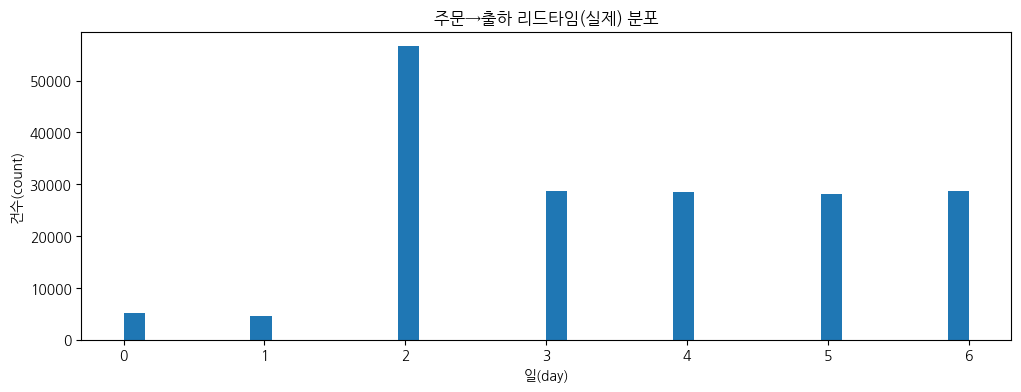

In [31]:
# 실 리드타임 분포 확인: 정상 범위/롱테일/이상치 감 잡기

vals = core_table["lt_real_days"].dropna()

plt.hist(vals, bins=40)
plt.title("주문→출하 리드타임(실제) 분포")
plt.xlabel("일(day)")
plt.ylabel("건수(count)")
plt.show()

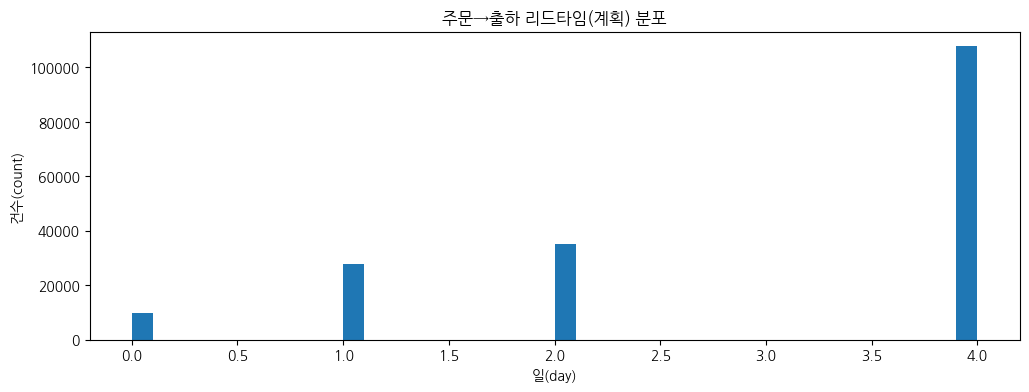

In [32]:
# 계획 리드타임 분포도 비교

if core_table["lt_sched_days"].notna().any():
    vals2 = core_table["lt_sched_days"].dropna()
    plt.hist(vals2, bins=40)
    plt.title("주문→출하 리드타임(계획) 분포")
    plt.xlabel("일(day)")
    plt.ylabel("건수(count)")
    plt.show()

계획 LT(hist)는 0, 1, 2, 4일에 몰림.

특히 0~2일의 비중이 커서 현실(평균 3.5일, P95 6일)과 차이가 큼.

### 2-3) 월별 OTD 추이 + 평균 리드타임 추이

In [34]:
# 월 키 생성: 주문월 기준

core_table["month_key"] = core_table["order_date"].dt.to_period("M")

monthly_kpi = (core_table
               .groupby("month_key")
               .agg(orders=("order_id","count"),
                    otd_rate=("otd_flag","mean"),
                    avg_real_lt=("lt_real_days","mean"))
               .reset_index())

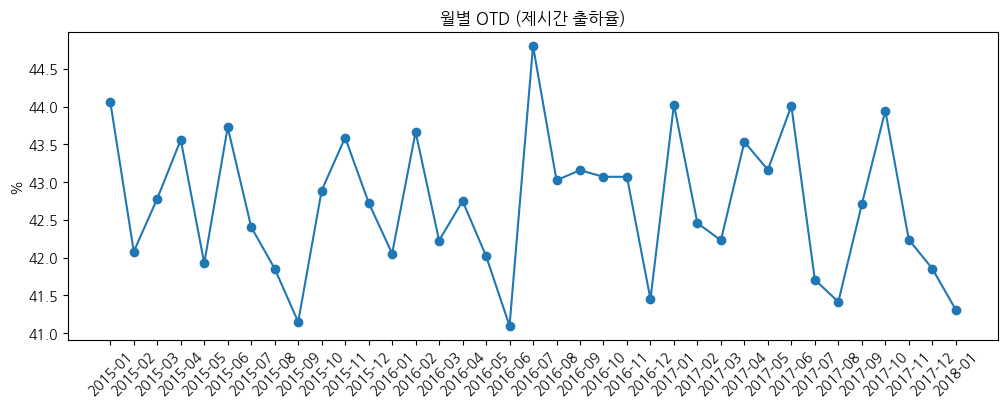

In [54]:
# OTD 추이

plt.plot(monthly_kpi["month_key"].astype(str), monthly_kpi["otd_rate"]*100, marker="o")
plt.xticks(rotation=45)
plt.title("월별 OTD (제시간 출하율)")
plt.ylabel("%")
plt.show()

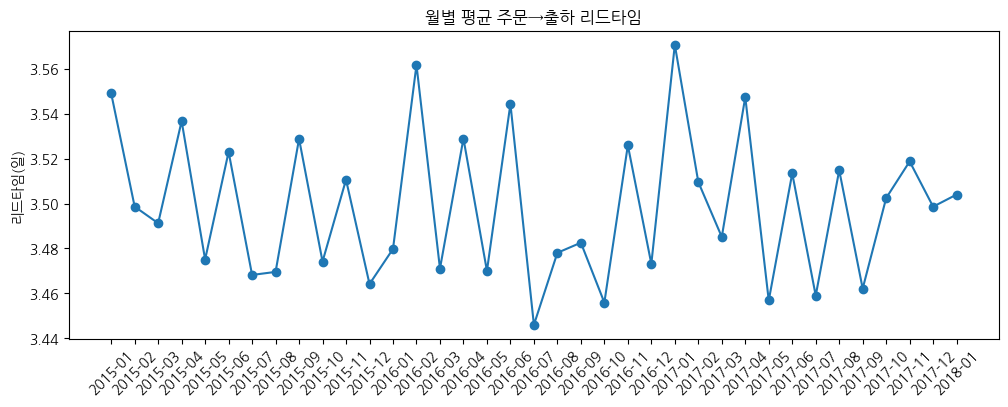

In [55]:
# 평균 리드타임 추이

plt.plot(monthly_kpi["month_key"].astype(str), monthly_kpi["avg_real_lt"], marker="o")
plt.xticks(rotation=45)
plt.title("월별 평균 주문→출하 리드타임")
plt.ylabel("리드타임(일)")
plt.show()

In [37]:
monthly_kpi.head()

,month_key,orders,otd_rate,avg_real_lt
0,2015-01,5322,0.440624,3.549042
1,2015-02,4729,0.420808,3.498626
2,2015-03,5362,0.427825,3.491235
3,2015-04,5126,0.435622,3.536676
4,2015-05,5357,0.419265,3.475079


### 2-4) 어디에서 지연이 많은가? (차원별 Top N)

In [38]:
# @title
# 그룹별 지연율 테이블
## 개선 우선순위를 잡기 위해 Top N을 봄

def build_late_table(table, group_col, top=10, min_count=100):
    g = (table.groupby(group_col)
         .agg(lines=("order_id","count"),
              late_rate=("late_flag","mean"),
              otd_rate=("otd_flag","mean"),
              avg_real_lt=("lt_real_days","mean"))
         .sort_values("late_rate", ascending=False))

    return g[g["lines"] >= min_count].head(top).round(3) # 표본이 너무 적은 그룹은 제외(신뢰도 확보)

late_by_mode    = build_late_table(core_table, "shipping_mode", top=10, min_count=50)
late_by_region  = build_late_table(core_table, "order_region",  top=10, min_count=100)
late_by_country = build_late_table(core_table, "order_country", top=10, min_count=100)
late_by_cat     = build_late_table(core_table, "category_name", top=10, min_count=100)

display(late_by_mode)
display(late_by_region)
display(late_by_country)
display(late_by_cat)

,lines,late_rate,otd_rate,avg_real_lt
shipping_mode,,,,
First Class,27814,1.000,0.000,2.000
Second Class,35216,0.797,0.203,3.991
Same Day,9737,0.478,0.522,0.478
Standard Class,107752,0.398,0.602,3.996


,lines,late_rate,otd_rate,avg_real_lt
order_region,,,,
Central Africa,1677,0.607,0.393,3.561
Western Europe,27109,0.585,0.415,3.498
South Asia,7731,0.585,0.415,3.502
South of USA,4045,0.581,0.419,3.493
Southeast Asia,9539,0.580,0.420,3.497
East of USA,6915,0.580,0.420,3.501
West Asia,6009,0.575,0.425,3.487
East Africa,1852,0.575,0.425,3.515
Eastern Europe,3920,0.574,0.426,3.501


,lines,late_rate,otd_rate,avg_real_lt
order_country,,,,
Ecuador,294,0.694,0.306,3.340
Níger,108,0.667,0.333,3.972
Mozambique,244,0.664,0.336,3.730
Irlanda,491,0.648,0.352,3.491
Trinidad y Tobago,138,0.645,0.355,4.138
Hungría,179,0.642,0.358,3.844
Somalia,141,0.638,0.362,2.979
Ghana,264,0.636,0.364,3.860
Angola,306,0.627,0.373,3.402


,lines,late_rate,otd_rate,avg_real_lt
category_name,,,,
Lacrosse,343,0.621,0.379,3.618
Cameras,592,0.620,0.380,3.338
Pet Supplies,492,0.614,0.386,3.388
Sporting Goods,357,0.599,0.401,3.490
Fitness Accessories,309,0.595,0.405,3.573
Crafts,484,0.595,0.405,3.579
Strength Training,111,0.595,0.405,3.748
Music,434,0.594,0.406,3.484
Boxing & MMA,423,0.593,0.407,3.468


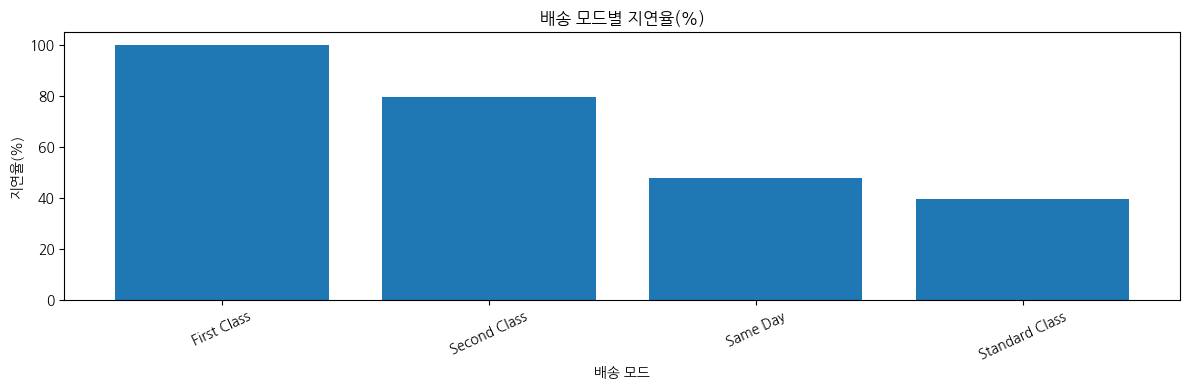

In [56]:
# 배송 모드별 지연율 그래프

if len(late_by_mode) > 0:
    order_idx = late_by_mode.sort_values("late_rate", ascending=False).index
    values = (late_by_mode.loc[order_idx, "late_rate"] * 100).values

    plt.bar(order_idx, values)
    plt.title("배송 모드별 지연율(%)")
    plt.xlabel("배송 모드")
    plt.ylabel("지연율(%)")
    plt.xticks(rotation=25)
    plt.tight_layout()
    plt.show()

### 2-5) 파레토 분석(상위 그룹이 지연 대부분을 유발?)

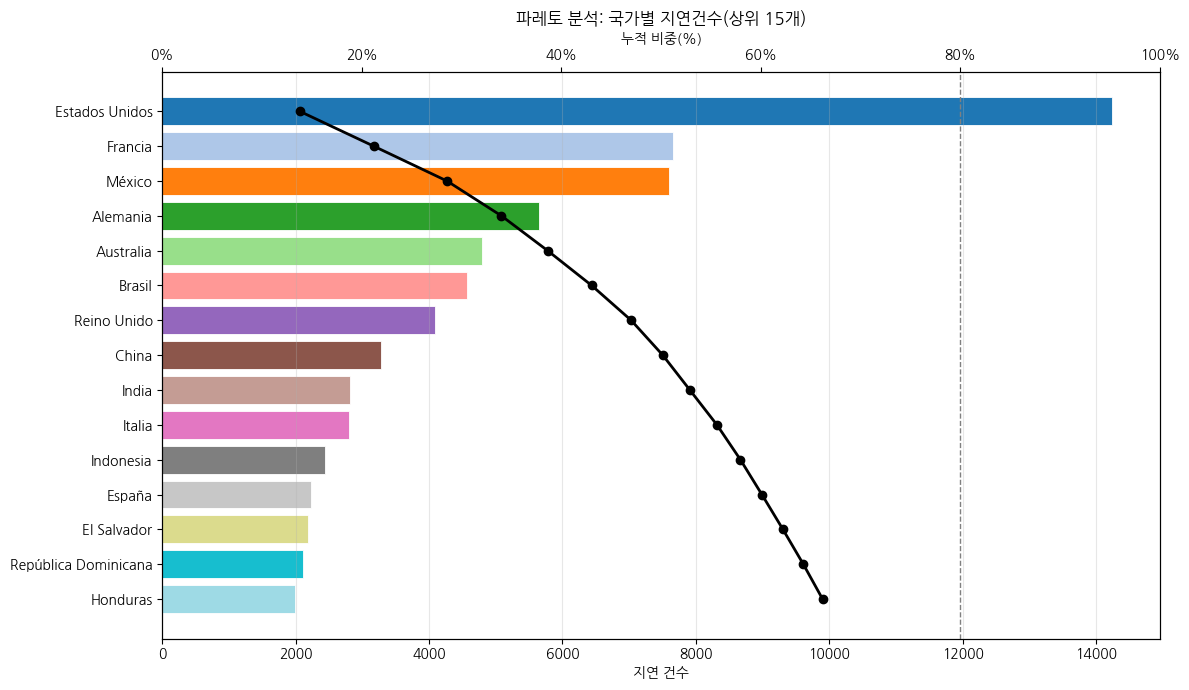

In [61]:
# 파레토분석
## 국가 기준 지연건수 누적 비중 → 상위 몇 개 국가가 전체 지연의 몇 %?

# 상위 15개
countries   = late_by_country_count["order_country"].head(15)
late_counts = late_by_country_count["late_flag"].head(15).values
cum_pct     = (late_by_country_count["cum_pct"].head(15) * 100).values

fig, ax1 = plt.subplots(figsize=(12, 7))

# 1) 가로 막대(지연 건수) — 길이가 길면 자동 줄바꿈/겹침 걱정 ↓
ypos = np.arange(len(countries))
palette = plt.cm.tab20(np.linspace(0, 1, len(countries)))  # 색 다양화
ax1.barh(ypos, late_counts, color=palette, edgecolor="white", linewidth=0.6)
ax1.set_yticks(ypos)
ax1.set_yticklabels(countries)
ax1.invert_yaxis()  # 값 큰 게 위로 오도록
ax1.set_xlabel("지연 건수")
ax1.set_title("파레토 분석: 국가별 지연건수(상위 15개)")
ax1.grid(axis="x", alpha=0.3)

# 2) 보조 x축(위쪽)에 누적 비중(%) 라인
ax2 = ax1.twiny()
ax2.plot(cum_pct, ypos, color="black", marker="o", linewidth=2, label="누적 비중(%)")
ax2.set_xlim(0, 100)
ax2.set_xlabel("누적 비중(%)")
ax2.xaxis.set_major_formatter(PercentFormatter(xmax=100))

# 3) 80% 기준선(파레토 룰)
ax2.axvline(80, color="gray", linestyle="--", linewidth=1, label="80% 기준선")

# 4) 80% 도달 지점 표시
idx80 = np.argmax(cum_pct >= 80) if np.any(cum_pct >= 80) else None
if idx80 is not None:
    ax2.scatter(cum_pct[idx80], ypos[idx80], color="red", zorder=5)
    ax2.annotate(
        f"상위 {idx80+1}개 국가가 80% 도달",
        xy=(cum_pct[idx80], ypos[idx80]),
        xytext=(min(95, cum_pct[idx80] + 8), ypos[idx80] + 0.5),
        arrowprops=dict(arrowstyle="->", color="red"),
        ha="left", va="center", color="red"
    )

plt.tight_layout()
plt.show()

검정 선은 ‘누적 비중(%)’ 곡선 -> 누적값은 증가 중 (오른쪽으로 갈수록 선이 아래로 내려가는 형태)

#3.원인분석

In [41]:
# 교차분석: 지역 × 배송모드 별 지연율 → 어느 조합이 특히 안 좋은지 확인

cross_late_table = pd.pivot_table(
    core_table,
    values="late_flag",
    index="order_region",
    columns="shipping_mode",
    aggfunc="mean"
).round(3)

cross_late_table

shipping_mode,First Class,Same Day,Second Class,Standard Class
order_region,,,,
Canada,1.0,0.333,0.771,0.304
Caribbean,1.0,0.534,0.819,0.372
Central Africa,1.0,0.304,0.825,0.449
Central America,1.0,0.487,0.784,0.402
Central Asia,1.0,0.203,0.906,0.434
East Africa,1.0,0.418,0.787,0.412
East of USA,1.0,0.483,0.787,0.415
Eastern Asia,1.0,0.485,0.838,0.387
Eastern Europe,1.0,0.360,0.754,0.410


#4.MRP 시뮬레이션

In [42]:
# 주차별 수요(=주문 수량 합계) 추출
core_table["week_key"] = core_table["order_date"].dt.to_period("W")
weekly_demand = core_table.groupby("week_key")["order_qty"].sum().reset_index()

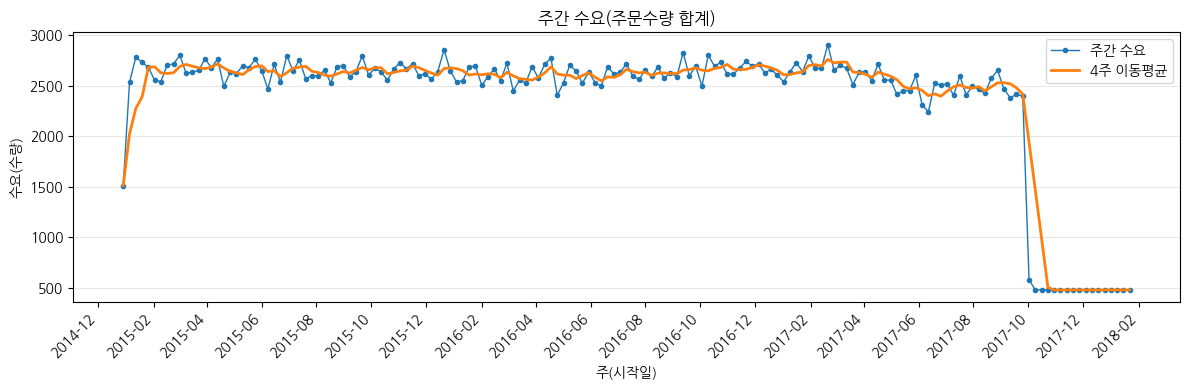

In [64]:
# 1) week_key를 datetime(해당 주의 시작일)로 변환해 '시간 축'으로 사용
weekly_plot = weekly_demand.copy()
weekly_plot["week_start"] = weekly_plot["week_key"].dt.start_time  # Period -> datetime

# 마지막 데이터가 '미완성 주'라면 제거 (끝값이 비정상적으로 작은 경우 방지)
# 마지막 주 시작일부터 원시 데이터 마지막 주문일까지 6일 미만이면 미완성으로 판단
last_order_date = core_table["order_date"].max()
if (last_order_date - weekly_plot["week_start"].iloc[-1]).days < 6:
    weekly_plot = weekly_plot.iloc[:-1]

# 4주 이동평균으로 추세선 추가
weekly_plot["order_qty_ma4"] = weekly_plot["order_qty"].rolling(window=4, min_periods=1).mean()


fig, ax = plt.subplots(figsize=(12, 4))

# 원 데이터 라인
ax.plot(weekly_plot["week_start"], weekly_plot["order_qty"], marker="o", markersize=3, linewidth=1, label="주간 수요")

# 이동평균(추세) 라인
ax.plot(weekly_plot["week_start"], weekly_plot["order_qty_ma4"], linewidth=2, label="4주 이동평균")

# 3) x축 눈금: 2개월 간격으로만 표시
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=2))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
plt.setp(ax.get_xticklabels(), rotation=45, ha="right")

# 4) 라벨/제목/그리드
ax.set_title("주간 수요(주문수량 합계)")
ax.set_xlabel("주(시작일)")
ax.set_ylabel("수요(수량)")
ax.grid(True, axis="y", alpha=0.3)
ax.legend(loc="upper right")

plt.tight_layout()
plt.show()

In [44]:
# 간단 MRP 가정 예시로 재현:
# - 현재 가용재고 current_stock
# - 리드타임(조달) leadtime_weeks
# - 안전재고 safety_stock

current_stock   = 1000
leadtime_weeks  = 2
safety_stock    = 300

In [45]:
# 부족 주차 계산
## 누적 수요가 재고+리드타임 이전에 안전재고 밑으로 내려가면 발주 필요

weekly_demand["cum_demand"] = weekly_demand["order_qty"].cumsum()
weekly_demand["projected_stock"] = current_stock - weekly_demand["cum_demand"]

In [46]:
# 리드타임을 고려한 발주 신호
## 예시: t+2주에 필요한 물량을 t의 시점에서 체크

weekly_demand["reorder_signal"] = (weekly_demand["projected_stock"].shift(-leadtime_weeks) <= safety_stock).astype(int)

In [47]:
weekly_demand.tail(10)

,week_key,order_qty,cum_demand,projected_stock,reorder_signal
152,2017-11-27/2017-12-03,480,380038,-379038,1
153,2017-12-04/2017-12-10,479,380517,-379517,1
154,2017-12-11/2017-12-17,480,380997,-379997,1
155,2017-12-18/2017-12-24,479,381476,-380476,1
156,2017-12-25/2017-12-31,480,381956,-380956,1
157,2018-01-01/2018-01-07,479,382435,-381435,1
158,2018-01-08/2018-01-14,480,382915,-381915,1
159,2018-01-15/2018-01-21,479,383394,-382394,1
160,2018-01-22/2018-01-28,480,383874,-382874,0
161,2018-01-29/2018-02-04,205,384079,-383079,0


#5.수요 예측 (Prophet)

In [48]:
# Prophet 설치

!pip install prophet -q
from prophet import Prophet

In [49]:
# Prophet이 요구하는 컬럼명(ds, y)으로 맞추기

demand_for_model = weekly_demand.rename(columns={"week_key":"ds","order_qty":"y"})
demand_for_model["ds"] = demand_for_model["ds"].dt.start_time  # period → datetime으로 변환

In [50]:
# 모델 학습

prophet_model = Prophet()
prophet_model.fit(demand_for_model)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpgfvh6bz9/n1xsuz9s.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpgfvh6bz9/9an_qeq6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=3710', 'data', 'file=/tmp/tmpgfvh6bz9/n1xsuz9s.json', 'init=/tmp/tmpgfvh6bz9/9an_qeq6.json', 'output', 'file=/tmp/tmpgfvh6bz9/prophet_model6k0iot5h/prophet_model-20250923035319.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
03:53:19 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
03:53:19 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [51]:
# 향후 12주 예측

future = prophet_model.make_future_dataframe(periods=12, freq="W")
forecast = prophet_model.predict(future)

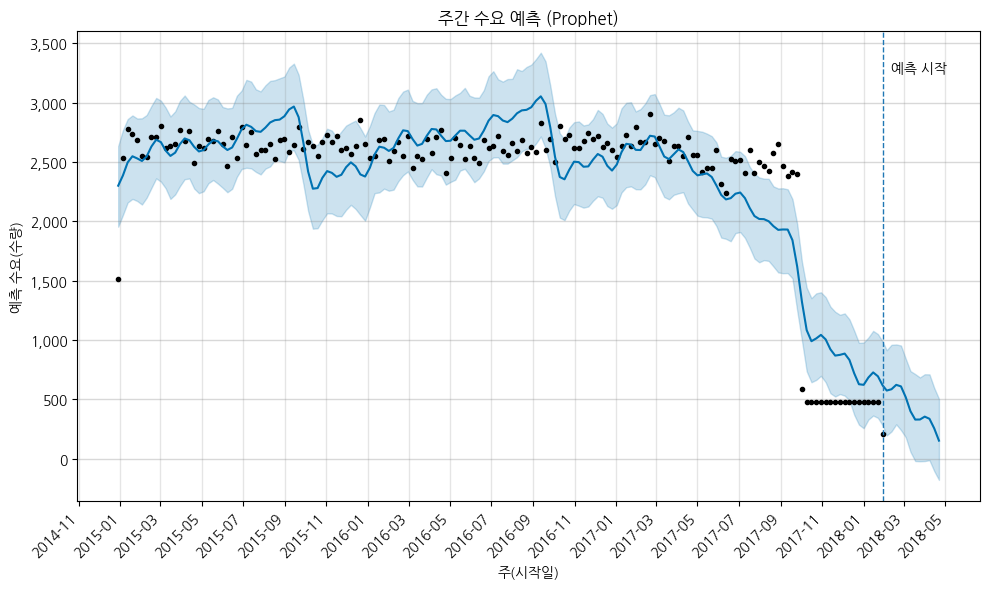

In [67]:
fig = prophet_model.plot(forecast)
ax = fig.axes[0]

ax.set_title("주간 수요 예측 (Prophet)")
ax.set_xlabel("주(시작일)")
ax.set_ylabel("예측 수요(수량)")

ax.xaxis.set_major_locator(mdates.MonthLocator(interval=2)) # 2개월 간격 눈금
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
plt.setp(ax.get_xticklabels(), rotation=45, ha="right")

ax.yaxis.set_major_formatter(StrMethodFormatter("{x:,.0f}"))

# 학습/예측 경계선 표시 (검정점이 끝난 지점 = 예측 시작점)
train_end = demand_for_model["ds"].max()
ax.axvline(train_end, linestyle="--", linewidth=1)
ax.annotate("예측 시작", xy=(train_end, ax.get_ylim()[1]),
            xytext=(6, -22), textcoords="offset points",
            ha="left", va="top")

ax.grid(True, axis="y", alpha=0.3)
plt.tight_layout()
plt.show()

원시 데이터 후반부(2017년 말~2018년 초)에 급락/제로 근처 값이 다수 → Prophet이 하향 추세를 강하게 반영.